In [1]:
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import os
import cv2
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
class_names = ['men', 'women']
class_names_label = {'men': 0,
                    'women' : 1
                    }
nb_classes = 2

In [3]:
size = (200,200)

output = []
directory = "../input/healthsignzgenderclassification/data/Training Set"

images = []
labels = []
for folder in os.listdir(directory):
    
    curr_label = class_names_label[folder]
    for file in os.listdir(directory + "/" + folder):
        img_path = directory + "/" + folder + "/" + file
        if not file.endswith('gif'): 
            curr_img = cv2.imread(img_path)
            curr_img = cv2.resize(curr_img, size)
        else:
            curr_img = load_img(img_path, target_size=size)
            curr_img = img_to_array(curr_img)
        images.append(curr_img)
        labels.append(curr_label)
images, labels = shuffle(images, labels)     ### Shuffle the data !!!
images = np.array(images, dtype = 'float32') ### Our images
labels = np.array(labels, dtype = 'int32')   ### From 0 to num_classes-1!

In [4]:
images = np.array(images) / 255.0

In [5]:
(trainX, testX, trainY, testY) = train_test_split(images, labels, test_size=0.2, random_state=50)

In [6]:
trainX = np.array(trainX).reshape(-1, 200,200,3)
trainY = np.array(trainY)
testX = np.array(testX).reshape(-1, 200,200,3)
testY = np.array(testY)

In [7]:
model = VGG16(weights = "imagenet", include_top=False, input_shape = (200, 200, 3))

58892288/58889256 [==============================] - 3s 0us/step


In [8]:
#Adding custom Layers 
x = model.output
x = Flatten()(x)
#x = Dense(512, activation="relu")(x)
#x = Dropout(0.25)(x)
#x = Dense(256, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

In [9]:
model_final = Model(input = model.input, output = predictions)
#for layer in model.layers:
#    layer.trainable = False

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [10]:
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [11]:
# compile the model 
model_final.compile(loss = "binary_crossentropy", optimizer = optimizers.RMSprop(lr=2e-5),metrics=["acc"])

In [12]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    #fill_mode="nearest"
    )

In [13]:
# Save the model according to the conditions  
callbacks_list = [
    ModelCheckpoint(filepath="best_reducelr_model.h5", monitor="val_loss", save_best_only=True)
]

In [14]:
H = model_final.fit_generator(
train_datagen.flow(trainX, trainY, batch_size=32),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // 64,
    epochs=100,
    callbacks = callbacks_list)

Epoch 1/100
33/33 [==============================] - 16s 484ms/step - loss: 0.6282 - acc: 0.6364 - val_loss: 0.5239 - val_acc: 0.7538
Epoch 2/100
33/33 [==============================] - 12s 354ms/step - loss: 0.5162 - acc: 0.7500 - val_loss: 0.4162 - val_acc: 0.8087
Epoch 3/100
33/33 [==============================] - 12s 370ms/step - loss: 0.4263 - acc: 0.7992 - val_loss: 0.3873 - val_acc: 0.8428
Epoch 4/100
33/33 [==============================] - 12s 370ms/step - loss: 0.4249 - acc: 0.7926 - val_loss: 0.3331 - val_acc: 0.8693
Epoch 5/100
33/33 [==============================] - 12s 371ms/step - loss: 0.3711 - acc: 0.8258 - val_loss: 0.2905 - val_acc: 0.8750
Epoch 6/100
33/33 [==============================] - 12s 369ms/step - loss: 0.3350 - acc: 0.8475 - val_loss: 0.2801 - val_acc: 0.8996
Epoch 7/100
33/33 [==============================] - 12s 370ms/step - loss: 0.3141 - acc: 0.8504 - val_loss: 0.2929 - val_acc: 0.8902
Epoch 8/100
33/33 [==============================] - 12s 368ms

<Figure size 432x288 with 0 Axes>

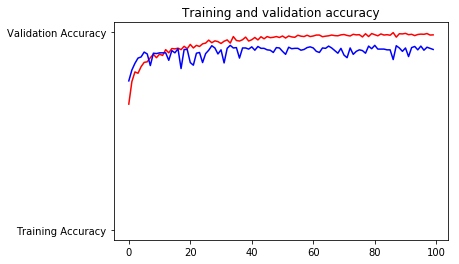

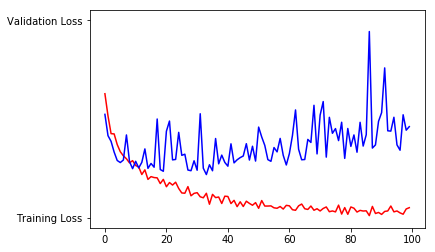

<Figure size 432x288 with 0 Axes>

In [15]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=H.history['acc']
val_acc=H.history['val_acc']
loss=H.history['loss']
val_loss=H.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

In [16]:
import numpy as np
from keras.preprocessing import image
fn = '2312.gif'
path = '../input/healthsignzgenderclassification/data/Testing Set/' + fn
if not fn.endswith('gif'): 
    curr_img = cv2.imread(path)
    curr_img = cv2.resize(curr_img, size)
else:
    curr_img = load_img(path, target_size=size)
    curr_img = img_to_array(curr_img)
images = np.array(curr_img, dtype = 'float32')
images = np.array(curr_img) / 255.0
images = np.array(images).reshape(-1, 200,200,3)
classes = model_final.predict(images, batch_size=32)
print(classes)
print(classes[0])
if classes[0]>0.5:
    print(fn + " is a women")
else:
    print(fn + " is a men")

[[0.11718481]]
[0.11718481]
2312.gif is a men


In [17]:
#model = resnet50.ResNet50(weights= None, include_top=False, input_shape= (200,200,3))